In [1]:
import torch

from sbi.inference import SNPE, SNPE_A, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

from astropy.table import Table

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font',**{'family':'serif','size':14})
#plt.rc('text', usetex=True)

In [2]:
def shift_cen(arr):    
    return arr[:-1] + (arr[1]-arr[0])/2.

def contour_plot(ax, xdata, ydata, limits, nbins=50, labels=["set1",], colours=['k',], nlevel=4, zeropoint=2):
    
    #alpha = np.array([1,0.8,0.6,0.4,0.2]) # can't use alpha
    lw = 1.5*np.arange(nlevel+1)/nlevel #[0.4, 0.8, 1.2, 1.6, 2]
    if type(colours[0]) is str:
        col = colours
    elif type(colours[0]) is int:
        col = np.array([BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']])[colours]
    else:
        col = [BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']]
    
    n_sets = len(xdata)
    if n_sets > 4:
        print("Error: can't plot more than four contour sets. {} requested".format(n_sets))
        return ax,[0,1]*2
        
    # find the axis limits, etc. (if not None, we assume they're fine)
    if limits is None:
        # find the 98%ile in each axis
        x_tmp = np.sort(np.hstack(xdata))
        y_tmp = np.sort(np.hstack(ydata))

        limits = [1.2*sorted(x_tmp)[int(0.01*len(x_tmp))]]
        limits.append(1.2*sorted(x_tmp)[int(0.99*len(x_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.01*len(y_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.99*len(y_tmp))])
            
    # 2d hist
    x_edges = limits[0] + (limits[1] - limits[0]) * np.arange(nbins+1) / nbins
    y_edges = limits[2] + (limits[3] - limits[2]) * np.arange(nbins+1) / nbins

    # plot each in turn
    for i in range(n_sets):
        z = np.histogram2d(xdata[i], ydata[i], bins=[x_edges, y_edges], density=True)
        if i==0:
            zmax = np.max(z[0])*0.98
            
        # contour levels
        levels = 10.**((np.arange(nlevel+1) * (np.log10(zmax)+zeropoint) / nlevel) - zeropoint)
        print(levels, np.log10(zmax), zmax, np.min(z[0]))

        X, Y = np.meshgrid(shift_cen(x_edges), shift_cen(y_edges))

        # plot
        ax.contour(X, Y, z[0].T, levels=levels, colors=col[i], linewidths=lw)
        
        ax_ranges = [ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0]]    
        ax.plot([ax.get_xlim()[1]+0.3*ax_ranges[0], ax.get_xlim()[1]+0.35*ax_ranges[0]], 
            [ax.get_ylim()[0]-0.3*ax_ranges[1], ax.get_ylim()[0]-0.3*ax_ranges[1]], label=labels[i], 
            color=col[i])

    ax.legend() #fontsize=22,loc=2 
    return ax, limits



In [3]:
#!pip install astropy

# try to load the model
# save the model
import pickle
#with open("SBI_DES_DF_posterior.pkl", "wb") as handle:
with open("SBI_DES_DF_posterior.pkl", 'rb') as file:
    posterior = pickle.load(file)
print(posterior)


Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


/home/will/anaconda3/envs/sbi/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [4]:
cat = Table.read("Y3_deep_fields_DB_wKNN_cat_COSMOS_training_zm.fits")
print(len(cat))

321638


In [5]:
# trim
trim = np.where((cat['bdf_mag_dered_calib_i']<26.)&
                #(cat['photoz']>0.02)&
                #(cat['photoz']<7.)&
                #(cat['lp_mass_best']>5.5)&
                #(cat['lp_mass_best']<12.5)&
                (cat['bdf_mag_dered_calib_Ks']>-99))[0]

cat = cat[trim]
print(len(cat))

215058


In [6]:
# shuffle
shuffle = np.random.choice(np.arange(len(cat)), len(cat), replace=False)
cat = cat[shuffle]

In [7]:
col_stem = 'bdf_flux_dered_calib_'

bands = ['u', 'g', 'r', 'i', 'z', 'J', 'H', 'Ks']

des_df_wav = np.array([3964.66514687, 4862.25686437, 6460.66067701, 7850.81307253,
                    9199.25312957, 12555.24560401, 16497.51745108, 21577.4382854])


In [8]:
flux = np.array([cat[col_stem+b] for b in bands])
flux.shape

(8, 215058)

In [9]:
def luptitudes(f,b=10):
    lupt = 2.5/np.log(10) * (np.arcsinh(f/(2*b)) + np.log(b))
    return lupt

lupt = luptitudes(flux).T


In [10]:
# convert the data to pytorch tensors, float32
#theta_tst_torch = torch.from_numpy(theta_test.astype(np.float32))
x_tst_torch = torch.from_numpy(lupt.astype(np.float32))



In [11]:
prior = utils.BoxUniform(low=torch.from_numpy(np.array([0.02, 5.5])), #, -1, -1])), 
                          high=torch.from_numpy(np.array([7, 12.5]))) #, 4, 4])))


In [12]:
ob = 207
print(lupt[ob,:])


[3.50550119 3.82660988 4.7700608  5.16725652 5.15433218 5.52740445
 5.6162943  5.71391742]


In [13]:
posterior.set_default_x(x_tst_torch[ob,:])
mode_val = posterior.map(num_iter=100, num_init_samples=10) # balanace of accruacy and speed
print(mode_val)

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([[0.5409, 8.3891]])


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

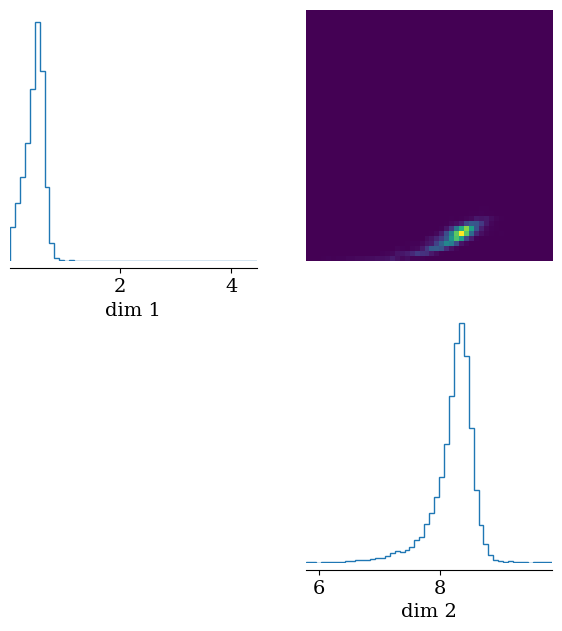

In [14]:
posterior_samples = posterior.sample((10000,), x=x_tst_torch[ob,:])
#posterior_samples = posterior.sample((100,), x=ob_x)
#posterior_samples = posterior((100,), x=ob_x, sample_with_mcmc=True)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(7, 7)
)
# limits=[[-2, 2], [-2, 2], [-2, 2]]
plt.show()

23.431855691323687 [5.87182584 6.03006846 6.23330575 6.56874804 6.75391021 7.24477131
 7.17841143 7.33154718]


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([[1.0326, 9.1776]])
0.25835258 2.3277538 8.003635 10.007063
[0.63095734 1.08434712 1.86353117 3.2026169  5.50393531 9.45892216] 0.9758416514645137 9.458922157989138 0.0


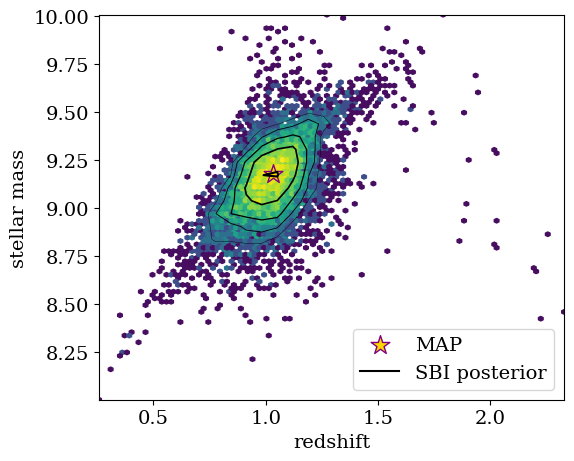

In [15]:
import matplotlib.colors as colors

#ob = 102
#ob = 58
#ob = 2
ob = 4
print(cat['bdf_mag_dered_calib_i'][ob], lupt[ob,:]) #, theta_test[ob,:])
posterior_samples = posterior.sample((10000,), x=x_tst_torch[ob,:])

posterior.set_default_x(x_tst_torch[ob,:])
mode_val = posterior.map(num_iter=100, num_init_samples=10) # balanace of accruacy and speed
print(mode_val)

# get the limits as the central 99%ile
z_tmp = np.sort(posterior_samples[:,0].numpy())
m_tmp = np.sort(posterior_samples[:,1].numpy())
z_min = z_tmp[int(0.0005*len(z_tmp))]
z_max = z_tmp[int(0.9995*len(z_tmp))]
m_min = m_tmp[int(0.0005*len(m_tmp))]
m_max = m_tmp[int(0.9995*len(m_tmp))]
print(z_min, z_max, m_min, m_max)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.hexbin(posterior_samples[:,0], posterior_samples[:,1],
          bins=30, norm=colors.LogNorm(vmin=0.9,vmax=25), extent=(z_min,z_max,m_min,m_max))
ax.scatter(mode_val.numpy()[0][0],mode_val.numpy()[0][1], marker='*', s=200, color='gold', edgecolors='purple', label='MAP')
contour_plot(ax, [posterior_samples[:,0],], [posterior_samples[:,1],],
             (z_min,z_max,m_min,m_max), nbins=30, labels=['SBI posterior',], colours=['k',], nlevel=5, zeropoint=0.2)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
ax.set_xlim([z_min,z_max])
ax.set_ylim([m_min,m_max])
plt.legend(loc=4)
plt.show()

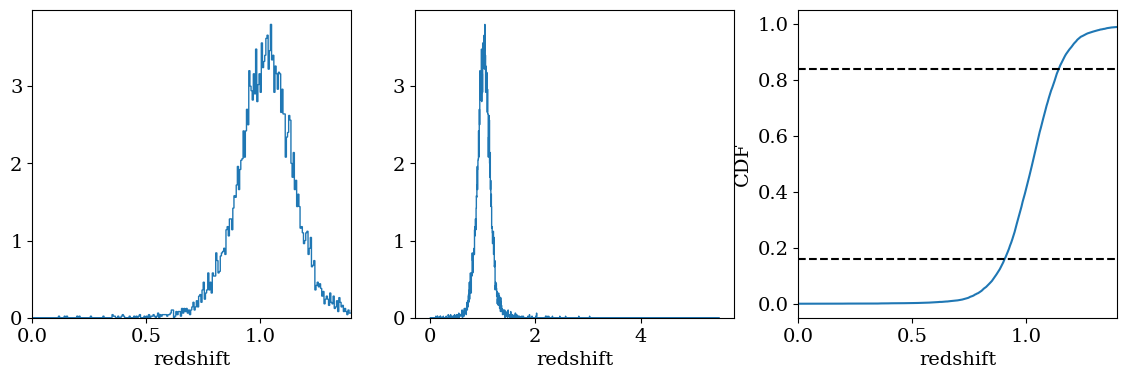

In [16]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(131)
ax.hist(posterior_samples[:,0], bins=np.arange(0,5.505,0.005), histtype='step', density=True)
ax.set_xlabel(r'redshift')
#ax.set_ylabel(r'stellar mass')
ax.set_xlim([0,1.4])
#ax.set_ylim([m_min,m_max])
ax2 = fig.add_subplot(132)
ax2.hist(posterior_samples[:,0], bins=np.arange(0,5.505,0.005), histtype='step', density=True)
ax2.set_xlabel(r'redshift')
ax3 = fig.add_subplot(133)
h, _ = np.histogram(posterior_samples[:,0], bins=np.arange(0,5.505,0.005))
h = np.cumsum(h) / np.cumsum(h)[-1]
ax3.plot(np.arange(0.005,5.505,0.005), h, '-')
ax3.plot([0.,1.4],[0.16,0.16],'k--')
ax3.plot([0.,1.4],[0.84,0.84],'k--')
ax3.set_xlim([0.,1.4])
ax3.set_xlabel(r'redshift')
ax3.set_ylabel(r'CDF')
#plt.legend(loc=4)
plt.show()

In [17]:
print("sigma:", (np.arange(0.005,5.505,0.005)[h>0.84][0]-np.arange(0.005,5.505,0.005)[h<0.16][-1])/(1+np.arange(0.005,5.505,0.005)[h>0.5][0]))
print(np.arange(0.005,5.505,0.005)[h<0.16][-1],np.arange(0.005,5.505,0.005)[h>0.84][0])

sigma: 0.11822660098522168
0.905 1.145


In [18]:
stop

NameError: name 'stop' is not defined

In [ ]:
# run them all! (takes too long, we'll split it)
pdz = np.zeros((lupt.shape[0],1100))
mode_vals = np.zeros((lupt.shape[0],2))
pcntiles = np.zeros((lupt.shape[0],3))
for ob in np.arange(lupt.shape[0]):
    
    posterior_samples = posterior.sample((10000,), x=x_tst_torch[ob,:])
    h, _ = np.histogram(posterior_samples[:,0], bins=np.arange(0,5.505,0.005), density=True)
    pdz[ob,:] = h
    
    posterior.set_default_x(x_tst_torch[ob,:])
    mode_vals[ob,:] = posterior.map(num_iter=100, num_init_samples=10).numpy()
    
    cum = np.cumsum(h) / np.cumsum(h)[-1]
    pcntiles[ob,0] = np.arange(0.005,5.505,0.005)[cum<0.16][-1]
    pcntiles[ob,1] = np.arange(0.005,5.505,0.005)[cum>0.5][0]
    pcntiles[ob,2] = np.arange(0.005,5.505,0.005)[cum>0.84][0]



In [ ]:
np.savez('DES_DF_COSMOS_SBI_zm.npz', mode=mode_vals, pdz=pdz, pcntiles=pcntiles)

In [ ]:
cum

In [ ]:
stop

In [ ]:
def shift_cen(arr):    
    return arr[:-1] + (arr[1]-arr[0])/2.

def contour_plot(ax, xdata, ydata, limits, nbins=50, labels=["set1",], colours=['k',], nlevel=4, zeropoint=2):
    
    #alpha = np.array([1,0.8,0.6,0.4,0.2]) # can't use alpha
    lw = 1.5*np.arange(nlevel+1)/nlevel #[0.4, 0.8, 1.2, 1.6, 2]
    if type(colours[0]) is str:
        col = colours
    elif type(colours[0]) is int:
        col = np.array([BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']])[colours]
    else:
        col = [BAND_COLORS['Y'], BAND_COLORS['g'], BAND_COLORS['r'], BAND_COLORS['u']]
    
    n_sets = len(xdata)
    if n_sets > 4:
        print("Error: can't plot more than four contour sets. {} requested".format(n_sets))
        return ax,[0,1]*2
        
    # find the axis limits, etc. (if not None, we assume they're fine)
    if limits is None:
        # find the 98%ile in each axis
        x_tmp = np.sort(np.hstack(xdata))
        y_tmp = np.sort(np.hstack(ydata))

        limits = [1.2*sorted(x_tmp)[int(0.01*len(x_tmp))]]
        limits.append(1.2*sorted(x_tmp)[int(0.99*len(x_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.01*len(y_tmp))])
        limits.append(1.2*sorted(y_tmp)[int(0.99*len(y_tmp))])
            
    # 2d hist
    x_edges = limits[0] + (limits[1] - limits[0]) * np.arange(nbins+1) / nbins
    y_edges = limits[2] + (limits[3] - limits[2]) * np.arange(nbins+1) / nbins

    # plot each in turn
    for i in range(n_sets):
        z = np.histogram2d(xdata[i], ydata[i], bins=[x_edges, y_edges], density=True)
        if i==0:
            zmax = np.max(z[0])*0.98
            
        # contour levels
        levels = 10.**((np.arange(nlevel+1) * (np.log10(zmax)+zeropoint) / nlevel) - zeropoint)
        print(levels, np.log10(zmax), zmax, np.min(z[0]))

        X, Y = np.meshgrid(shift_cen(x_edges), shift_cen(y_edges))

        # plot
        ax.contour(X, Y, z[0].T, levels=levels, colors=col[i], linewidths=lw)
        
        ax_ranges = [ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0]]    
        ax.plot([ax.get_xlim()[1]+0.3*ax_ranges[0], ax.get_xlim()[1]+0.35*ax_ranges[0]], 
            [ax.get_ylim()[0]-0.3*ax_ranges[1], ax.get_ylim()[0]-0.3*ax_ranges[1]], label=labels[i], 
            color=col[i])

    ax.legend() #fontsize=22,loc=2 
    return ax, limits



In [ ]:
cat = Table.read("Y3_deep_fields_DB_wKNN_cat_COSMOS_training_zm.fits")
print(len(cat))

In [ ]:
# trim
trim = np.where((cat['bdf_mag_dered_calib_i']<26.)&
                (cat['photoz']>0.02)&
                (cat['photoz']<7.)&
                (cat['lp_mass_best']>5.5)&
                (cat['lp_mass_best']<12.5)&
                (cat['bdf_mag_dered_calib_Ks']>-99))[0]

cat = cat[trim]
print(len(cat))

In [ ]:
# shuffle
shuffle = np.random.choice(np.arange(len(cat)), len(cat), replace=False)
cat = cat[shuffle]

In [ ]:
col_stem = 'bdf_flux_dered_calib_'

bands = ['u', 'g', 'r', 'i', 'z', 'J', 'H', 'Ks']

des_df_wav = np.array([3964.66514687, 4862.25686437, 6460.66067701, 7850.81307253,
                    9199.25312957, 12555.24560401, 16497.51745108, 21577.4382854])


In [ ]:
flux = np.array([cat[col_stem+b] for b in bands])
zm = np.array([cat['photoz'], cat['lp_mass_best']])


In [ ]:
flux.shape

In [ ]:
def luptitudes(f,b=10):
    lupt = 2.5/np.log(10) * (np.arcsinh(f/(2*b)) + np.log(b))
    return lupt

lupt = luptitudes(flux)


In [ ]:
# # use lupticolurs instead, plus an amplitude
# lupti_col = x_sim[:,:-1]-x_sim[:,1:]
# # put amplitude (i-band) at the end
# x_sim[:,-1] = x_sim[:,3]
# # fill in the colours into the rest
# x_sim[:,:-1] = lupti_col

In [ ]:
test_indx = int(0.8*len(cat))

theta_train = zm[:,:test_indx].T
x_train = lupt[:,:test_indx].T

theta_test = zm[:,test_indx:].T
x_test = lupt[:,test_indx:].T

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(theta_train[:,0], theta_train[:,1], '.', alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
ax.set_xlim([0,6])
ax.set_ylim([5,12])
plt.show()

In [ ]:
# convert the data to pytorch tensors, float32
theta_trn_torch = torch.from_numpy(theta_train.astype(np.float32))
x_trn_torch = torch.from_numpy(x_train.astype(np.float32))

theta_tst_torch = torch.from_numpy(theta_test.astype(np.float32))
x_tst_torch = torch.from_numpy(x_test.astype(np.float32))



In [ ]:
prior = utils.BoxUniform(low=torch.from_numpy(np.array([0.02, 5.5])), #, -1, -1])), 
                          high=torch.from_numpy(np.array([7, 12.5]))) #, 4, 4])))


In [ ]:
stop

In [ ]:
# build the density
inference = SNPE(prior=prior) # z_score_x='none' (where does this thing go?) 
inference = inference.append_simulations(theta_trn_torch, x_trn_torch)
density_estimator = inference.train()
#density_estimator = 

In [ ]:
posterior = inference.build_posterior(density_estimator)


In [ ]:
#ob = 158
#ob = 200
#ob = 201
#ob = 202
#ob = 206
ob = 207
print(x_test[ob,:], theta_test[ob,:])

#ob_x = np.array([-2.87335175, -2.25362532, -0.61331612, -0.41159564, -0.63459093, -0.63265751, -0.54153502, 9.58833485])
#ob_x = torch.from_numpy(ob_x.astype(np.float32))

In [ ]:
posterior_samples = posterior.sample((10000,), x=x_tst_torch[ob,:])
#posterior_samples = posterior.sample((100,), x=ob_x)
#posterior_samples = posterior((100,), x=ob_x, sample_with_mcmc=True)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(7, 7)
)
# limits=[[-2, 2], [-2, 2], [-2, 2]]
plt.show()

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(posterior_samples[:,0], posterior_samples[:,1], '.', alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
import matplotlib.colors as colors

ob = 208
print(x_test[ob,:], theta_test[ob,:])
posterior_samples = posterior.sample((10000,), x=x_tst_torch[ob,:])

posterior.set_default_x(x_tst_torch[ob,:])
mode_val = posterior.map(num_iter=100, num_init_samples=10) # balanace of accruacy and speed
print(mode_val)

# get the limits as the central 99%ile
z_tmp = np.sort(posterior_samples[:,0].numpy())
m_tmp = np.sort(posterior_samples[:,1].numpy())
z_min = z_tmp[int(0.0005*len(z_tmp))]
z_max = z_tmp[int(0.9995*len(z_tmp))]
m_min = m_tmp[int(0.0005*len(m_tmp))]
m_max = m_tmp[int(0.9995*len(m_tmp))]
print(z_min, z_max, m_min, m_max)

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111)
ax.hexbin(posterior_samples[:,0], posterior_samples[:,1],
          bins=30, norm=colors.LogNorm(vmin=0.9,vmax=25), extent=(z_min,z_max,m_min,m_max))
ax.scatter(mode_val.numpy()[0][0],mode_val.numpy()[0][1], marker='*', s=200, color='gold', edgecolors='purple', label='MAP')
contour_plot(ax, [posterior_samples[:,0],], [posterior_samples[:,1],],
             (z_min,z_max,m_min,m_max), nbins=30, labels=['SBI posterior',], colours=['k',], nlevel=5, zeropoint=0.2)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
ax.set_xlim([z_min,z_max])
ax.set_ylim([m_min,m_max])
plt.legend(loc=4)
plt.show()


In [ ]:
posterior.set_default_x(x_tst_torch[ob,:])
mode_val = posterior.map(num_iter=100, num_init_samples=10) # balanace of accruacy and speed
print(mode_val)

In [ ]:
# save the model
import pickle
with open("SBI_DES_DF_posterior.pkl", "wb") as handle:
    pickle.dump(posterior, handle)

In [ ]:
mode_vals = np.zeros((x_test.shape[0],2))
for ob in np.arange(x_test.shape[0]):
    posterior.set_default_x(x_tst_torch[ob,:])
    mode_vals[ob,:] = posterior.map(num_iter=100, num_init_samples=10).numpy()




In [ ]:
mode_val.numpy()

In [ ]:
import matplotlib.colors as colors


fig = plt.figure(figsize=(6.5,6))
ax = fig.add_subplot(111)
ax.hexbin(theta_test[:,0], mode_vals[:,0], extent=(0,5,0,5), bins=50,
         norm=colors.LogNorm(vmin=0.8, vmax=50))
ax.set_xlabel(r'true redshift (COSMOS2020)')
ax.set_ylabel(r'photo-z')
#fig.colorbar(s, label=r'sSFR')
ax.set_xlim([0,5])
ax.set_ylim([0,5])
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5.3))
ax = fig.add_subplot(121)
ax.hexbin(theta_test[:,0], mode_vals[:,0], extent=(0,1.6,0,1.6), bins=50,
         norm=colors.LogNorm(vmin=0.8, vmax=50))
ax.plot([0,1.6],[0,1.6],'-',c='r')
ax.plot([0,1.6],[0+0.15,1.6+(0.15*2.6)],'--',c='r', alpha=0.4)
ax.plot([0,1.6],[0-0.15,1.6-(0.15*2.6)],'--',c='r', alpha=0.4)
ax.set_xlabel(r'z-spec')
ax.set_ylabel(r'z-phot')
ax.set_xlim([0,1.6])
ax.set_ylim([0,1.6])
ax = fig.add_subplot(122)
ax.hexbin(theta_test[:,0], mode_vals[:,0], extent=(0,6,0,6), bins=50,
         norm=colors.LogNorm(vmin=1, vmax=50))
ax.plot([0,6],[0,6],'-',c='r')
ax.plot([0,6],[0+0.15,6+(0.15*7)],'--',c='r', alpha=0.4)
ax.plot([0,6],[0-0.15,6-(0.15*7)],'--',c='r', alpha=0.4)
ax.set_xlabel(r'z-spec')
ax.set_ylabel(r'z-phot')
ax.set_xlim([0,6])
ax.set_ylim([0,6])
#plt.savefig("new_PP_median_z.png")
plt.tight_layout()
plt.show()

In [ ]:
def compute_stats(zspec, zphot, pdz=None):
    dz = (zspec-zphot)/(1+zspec)
    not_out = (np.abs(dz)<0.15)
    print("N spec, {}".format(len(zspec)))
    print("Outlier fraction, {0:.4f}%".format(100*len(dz[np.abs(dz)>0.15])/len(zspec)))
    print("NMAD, {0:.4f}".format(1.4826*np.median(np.abs(dz-np.median(dz)))))
    print("mean (normalised) bias, {0:.4f}".format(np.mean(dz)))
    sig68 = np.percentile(dz,(16,84))
    print("Sigma-68, {0:.4f}".format((sig68[1]-sig68[0])/2))
    print("Outlier removed stats,")
    print("NMAD, {0:.4f}".format(1.4826*np.median(np.abs(dz-np.median(dz))[not_out])))
    print("mean (normalised) bias, {0:.4f}".format(np.mean(dz[not_out])))
    sig68 = np.percentile(dz[not_out],(16,84))
    print("Sigma-68, {0:.4f}".format((sig68[1]-sig68[0])/2))

compute_stats(theta_test[:,0], mode_vals[:,0])

In [ ]:
bright = np.where((30-2.5*np.log10(flux[3,test_indx:])<25.))[0]

In [ ]:
fig = plt.figure(figsize=(10,5.3))
ax = fig.add_subplot(121)
ax.hexbin(theta_test[bright,0], mode_vals[bright,0], extent=(0,1.6,0,1.6), bins=50,
         norm=colors.LogNorm(vmin=0.8, vmax=50))
ax.plot([0,1.6],[0,1.6],'-',c='r')
ax.plot([0,1.6],[0+0.15,1.6+(0.15*2.6)],'--',c='r', alpha=0.4)
ax.plot([0,1.6],[0-0.15,1.6-(0.15*2.6)],'--',c='r', alpha=0.4)
ax.set_xlabel(r'z-spec')
ax.set_ylabel(r'z-phot')
ax.set_xlim([0,1.6])
ax.set_ylim([0,1.6])
ax = fig.add_subplot(122)
ax.hexbin(theta_test[bright,0], mode_vals[bright,0], extent=(0,6,0,6), bins=50,
         norm=colors.LogNorm(vmin=1, vmax=50))
ax.plot([0,6],[0,6],'-',c='r')
ax.plot([0,6],[0+0.15,6+(0.15*7)],'--',c='r', alpha=0.4)
ax.plot([0,6],[0-0.15,6-(0.15*7)],'--',c='r', alpha=0.4)
ax.set_xlabel(r'z-spec')
ax.set_ylabel(r'z-phot')
ax.set_xlim([0,6])
ax.set_ylim([0,6])
#plt.savefig("new_PP_median_z.png")
plt.tight_layout()
plt.show()

In [ ]:
compute_stats(theta_test[bright,0], mode_vals[bright,0])

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hexbin(mode_vals[bright,0], mode_vals[bright,1], bins=50)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
ax.set_xlim([0,6])
ax.set_ylim([6,12])
plt.show()

In [ ]:
mode_vals[23,0]

In [ ]:
stop_here

In [ ]:
#tensor([[2.5784, 9.3111]])

In [ ]:
# load data - might need to scale the data a bit, with lupts etc.
theta = np.load("galaxy_pp.npz")['arr_0']
x_sim = np.load("photometry_obs.npz")['arr_0']

In [ ]:
# let's cut at i~26
icut = (30-2.5*np.log10(x_sim[:,3])<26)

theta = theta[icut,:]
x_sim = x_sim[icut,:]

In [ ]:
# drop the Y-bands for Y3 DF
keep_bands = np.array([0, 1, 2, 3, 4, 7, 8, 9])
x_sim = x_sim[:,keep_bands]

In [ ]:
def lupt(im, b=2.5):
    lupt_im = 2.5/np.log(10) * (np.arcsinh(im/(2*b)) + np.log(b))
    return lupt_im

# transform fluxes to lupts
x_sim = lupt(x_sim)

In [ ]:
# use lupticolurs instead, plus an amplitude
lupti_col = x_sim[:,:-1]-x_sim[:,1:]
# put amplitude (i-band) at the end
x_sim[:,-1] = x_sim[:,3]
# fill in the colours into the rest
x_sim[:,:-1] = lupti_col

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(theta[:,0], theta[:,1], '.', alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
# random order
reorder = np.random.choice(np.arange(theta.shape[0]), theta.shape[0], replace=False)

theta = theta[reorder,:]
x_sim = x_sim[reorder,:]

In [ ]:
subsamp = 1
if subsamp > 1:
    theta = theta[::subsamp,:]
    x_sim = x_sim[::subsamp,:]

In [ ]:
# focus on redshift, mass, sfr, mean age and UVJ, Av
#pp_select = np.array([0,1,2,3,4,5,9])
pp_select = np.array([0,1,4,5])
theta = theta[:,pp_select]

In [ ]:
# change sfr, mean age to log values
#theta[:,2:4] = np.log10(theta[:,2:4])

In [ ]:
theta

In [ ]:
good = np.isfinite(np.sum(theta, axis=1))

theta = theta[good,:]
x_sim = x_sim[good,:]

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(theta[:,0], theta[:,1], '.', alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
plt.hist(theta[:,1], bins=100)

In [ ]:
x_sim

In [ ]:
# convert the data to pytorch tensors, float32
theta_torch = torch.from_numpy(theta.astype(np.float32))
x_torch = torch.from_numpy(x_sim.astype(np.float32))

In [ ]:
x_sim.shape

In [ ]:
theta_torch

In [ ]:
print(x_sim[2,:])
print(theta[2,:])

In [ ]:
x_torch

In [ ]:
# prior = utils.BoxUniform(low=torch.from_numpy(np.array([0.02, 5.5, -5, -2, -1,-1,0])), 
#                           high=torch.from_numpy(np.array([7, 12.5, 3, 1.3, 4,4,3])))
prior = utils.BoxUniform(low=torch.from_numpy(np.array([0.02, 5.5, -1, -1])), 
                          high=torch.from_numpy(np.array([7, 12.5, 4, 4])))


In [ ]:
# build the density
inference = SNPE(prior=prior) # z_score_x='none' (where does this thing go?) 
inference = inference.append_simulations(theta_torch, x_torch)
density_estimator = inference.train()
#density_estimator = 

In [ ]:
posterior = inference.build_posterior(density_estimator)


In [ ]:
# example object
#ob_x = np.array([228.675, 234.417, 276.868, 486.681, 649.263, 536.633, 583.217, 654.117])
#ob_x = np.array([188.26, 222.95, 265.76, 289.00, 329.41, 732.76, 874.98, 1079.78])
#ob_x = np.array([100,150,500,600,1000,1200,1300,1500])
#ob_x = np.array([1453., 2264., 6198., 9067., 11586., 17695., 26503., 34032.])
#ob_x = np.array([33.3, 87.3, 278., 450., 552.1, 964., 1334.6, 1646.5])
#ob_x = np.array([-19.45, 65.88, 283.07, 633.95, 855.48, 1358.57, 1820.13, 2161.53])

des_df_wav = np.array([3964.66514687, 4862.25686437, 6460.66067701, 7850.81307253,
                    9199.25312957, 12555.24560401, 16497.51745108, 21577.4382854])

print(30-2.5*np.log10(ob_x))

In [ ]:
# plot SED, so we know what to expect
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(des_df_wav, ob_x/des_df_wav, 'o', alpha=0.6)
ax.set_xlabel(r'wavelen')
ax.set_ylabel(r'$\nu$f$_{\nu}$')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(des_df_wav, ob_x, 'o', alpha=0.6)
ax.set_xlabel(r'wavelen')
ax.set_ylabel(r'f$_{\nu}$')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
# use lupticolurs instead, plus an amplitude
ob_x = lupt(ob_x)
print(ob_x)
lupti_col = ob_x[:-1]-ob_x[1:]
# put amplitude (i-band) at the end
ob_x[-1] = ob_x[3]
# fill in the colours into the rest
ob_x[:-1] = lupti_col
print(ob_x)

In [ ]:
# plot SED, so we know what to expect
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(des_df_wav[:-1], ob_x[:-1], 'o', alpha=0.6)
ax.set_xlabel(r'wavelen')
ax.set_ylabel(r'Lupti-colour')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
#ob_x = np.array([-1.10344085, -0.30636154, -0.07680047, -0.0337393, -0.41660926, -0.30227358, 0.06104289, 5.59999046])
#ob_x = np.array([-6.56646888, -1.62230179, -0.25945062, -0.15442817, -0.2822111, -0.46721021, -0.40470592, 8.42329511])
ob_x = np.array([-2.87335175, -2.25362532, -0.61331612, -0.41159564, -0.63459093, -0.63265751, -0.54153502, 9.58833485])

ob_x = torch.from_numpy(ob_x.astype(np.float32))

In [ ]:
# doesn't work, the warning in the following cell is stupid
#posterior = inference.build_posterior(sample_with='mcmc')

In [ ]:
ob_x

In [ ]:
posterior_samples = posterior.sample((10000,), x=ob_x)
#posterior_samples = posterior.sample((100,), x=ob_x)
#posterior_samples = posterior((100,), x=ob_x, sample_with_mcmc=True)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(13, 13)
)
# limits=[[-2, 2], [-2, 2], [-2, 2]]
plt.show()

# [2.87224758 9.146033   0.01837601 0.39677599]
# [ 3.63128284 11.19292029  0.45862937  0.86052902]
# [ 3.912932   12.215409    0.61148523  1.38010781]

In [ ]:
posterior_samples

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(posterior_samples[:,0], posterior_samples[:,1], '.', alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,9))
ax = fig.add_subplot(111)
#ax.plot(posterior_samples[:,0], posterior_samples[:,1], '.', alpha=0.03)
ax.hexbin(posterior_samples[:,0], posterior_samples[:,1], extent=(0,1.5,8,11.5)) #, alpha=0.03)
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'stellar mass')
#fig.colorbar(s, label=r'sSFR')
#ax.set_xlim([0,4])
#plt.savefig("SBI_example.png")
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.hist(posterior_samples[:,0], bins=np.arange(400)/100, histtype='step')
ax.set_xlabel(r'redshift')
ax.set_ylabel(r'p(z)')
#fig.colorbar(s, label=r'sSFR')
ax.set_xlim([0,4])
plt.show()

print(np.percentile(posterior_samples[:,0], (16, 50, 84)))

In [ ]:
fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(111)
ax.hexbin(theta[:,3], theta[:,2], extent=(-1,4,-1,4), bins='log')
# because I accidentally logged the UVJ, I need to raise to power here.
ax.scatter(np.mean(posterior_samples[:,3].numpy()), 
           np.mean(posterior_samples[:,2].numpy()), 
           marker='*', s=400, alpha=0.8, c='red')
ax.set_xlabel(r'V - J $_{{\rm rest}}$')
ax.set_ylabel(r'U - V $_{{\rm rest}}$')
#ax.set_xlim([-1.4,0.4])
#ax.set_ylim([-1,0.5])

plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
s=ax.scatter(x_sim[:,1], x_sim[:,4], marker='.', alpha=0.3, c=theta[:,0], vmax=2.5)
ax.scatter(ob_x[1], ob_x[4], marker='*', s=120, alpha=0.8, c='k')
ax.set_xlabel(r'g - r $_{lupt}$')
ax.set_ylabel(r'z - Y $_{lupt}$')
ax.set_xlim([-1.4,0.4])
ax.set_ylim([-1,0.5])
fig.colorbar(s, label=r'redshift')

plt.show()